# Arxiv Co-authorship network - Perliminary analysis

In [19]:
from authors_net.builder import AuthorsNetwork
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy

## Network Data:

Read full network file: 

In [2]:
network_filename = 'network_data_merged.pickle'
net = pd.read_pickle(network_filename)

Convert to networkx object:

In [3]:
# initiate network builder:
network = AuthorsNetwork(filename='arxiv-metadata-oai-snapshot.json',
                        max_rows=None,
                        chunk_size=1000,
                        extra_edge_features=False, 
                        num_consumers=1, num_producers=1)
# use loaded df as builder result
network.network_df = net

# convert to networkx:
G = network.to_networkx()

Converting to NetworkX: 100%|██████████| 4689025/4689025 [05:24<00:00, 14453.67it/s]


## Some network basic statistics:

In [4]:
print(f'Number of edges in network: {G.number_of_edges()}')
print(f'Number of nodes in network: {G.number_of_nodes()}')

Number of edges in network: 4689025
Number of nodes in network: 151607


Generate degree distribution, and see if it fits the Power Law: <br>
- We estimate the power $\alpha$ of the power law distribution $P(k) \propto k^{\alpha}$ to the degree distribution, by doing a linear regression of the log of the frequency $log(f_k)$ vs. the log of the degree $log(k)$. we also remove the top and bottom $1\%$ of the degrees before fitting, to allow a better fit to the bulk of the distribution, and not the outliers (very high/low degrees). 

In [5]:
def fit_power_law_alpha(degrees, trim_p):
  """ 
  This function gets a degree vector of a graph and calculates its alpha coefficient 
  as in power low P(k) = k^alpha using linear regression
  -- degrees: degree vector
  -- trim_p: percentage of values to trim from both sides
  """
  # fit a model to estimate alpha: 
  k_, count_k_ = np.unique(list(degrees.values()), return_counts=True)  # returns sorted array of degrees with their counts
  f_k_ = count_k_ / sum(count_k_)  # convert counts to frequency
  # trim top and bottom 5%:
  to_trim = len(k_)*trim_p//100  # number of elements to trim from each side
  k_, f_k_ = k_[to_trim : -to_trim], f_k_[to_trim : -to_trim]
  # log scale both (avoid possible log(0)):
  k_, f_k_ = np.log(k_[k_>0]), np.log(f_k_)
  # fit model:
  estim_ = scipy.stats.linregress(k_, f_k_) 
  # alpha is the slope: 
  alpha_, intercept_ = estim_.slope, estim_.intercept

  return k_, f_k_, alpha_, intercept_ 

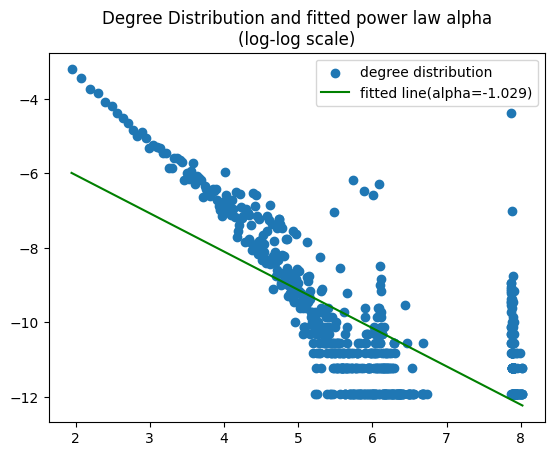

In [10]:
# degree distribution:
degrees = sorted(G.degree, key=lambda x: x[1], reverse=True)
degrees = dict(degrees)
# calculate alpha and intercept: 
k, f_k, alpha, intercept = fit_power_law_alpha(degrees, trim_p=1)
# plot:
plt.scatter(k, f_k, label="degree distribution")
plt.plot(k, alpha*k + intercept, color="g", label=f'fitted line(alpha={alpha:.3f})')
plt.legend()
plt.title('Degree Distribution and fitted power law alpha\n(log-log scale)')
plt.show()

As can be seen from the plot, the degree distribution does not follow the power law very accurately, but the general shape of the distribution does exist.

An important measureof the network, could be the global clustering coefficient, a measure of the degree to which nodes in a graph tend to cluster together. we calculate that measure here:

In [18]:
print(f'Network global clustering coefficient: {nx.transitivity(G)}')

0.9847700377177347